## Analysis of the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

plt.style.use('seaborn')

# Load data

file = pd.read_csv('Data.csv', sep=';')
df = pd.DataFrame(file)



In [2]:
def preprocessing(data):

    # Do first stage pre-processing (i.e. exclude non-numeric prices and convert prices to numeric variables)

    data = data[data.price_new.str.contains("aanvraag") == False].dropna()
    data[['price_new']] = data[['price_new']].apply(pd.to_numeric)

    # exclude everything with a price above or below 3 standard deviations (i.e. outliers)

    data = data[np.abs(data["price_new"]-data["price_new"].mean())<=(3*data["price_new"].std())]

    # Set x and y (dropping zipcode and rooms as latitude, longitude and surface pretty much capture the former)

    y = data.price_new
    X = data.drop('price_new', axis = 1).drop('zipcode_new', axis = 1).drop('rooms_new', axis = 1)

    return data, X, y

# Execute preprocessing

data, X, y = preprocessing(df)



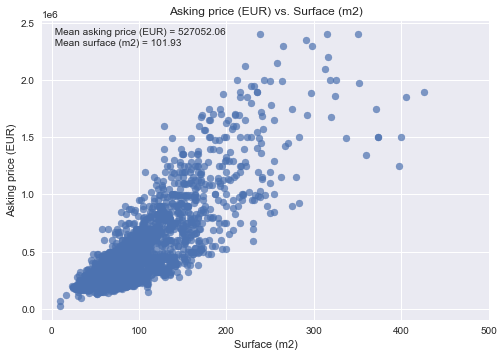

In [3]:
# Descriptives

# Scatterplot - Asking Price (EUR) vs. Surface (m2)

plt.scatter(data['surface'], data['price_new'], alpha=0.7, label='Asking price (EUR) vs. Surface (m2)')
plt.xticks([0,100,200, 300, 400,500])
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000])
plt.ylabel('Asking price (EUR)')
plt.xlabel('Surface (m2)')
plt.title('Asking price (EUR) vs. Surface (m2)')
plt.text(0,2400000, ' Mean asking price (EUR) = {}'.format(round(float(data['price_new'].mean()), 2)))
plt.text(0,2300000, ' Mean surface (m2) = {}'.format(round(float(data['surface'].mean()), 2)))
plt.show()


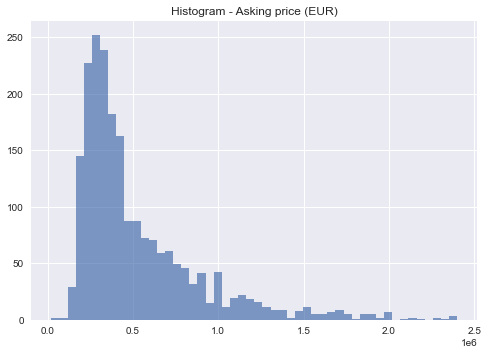

In [4]:
# Histogram - Asking Price (EUR)

plt.hist(data['price_new'], bins=50, density=False, histtype='stepfilled', alpha=0.7)
plt.title('Histogram - Asking price (EUR)')
plt.show()



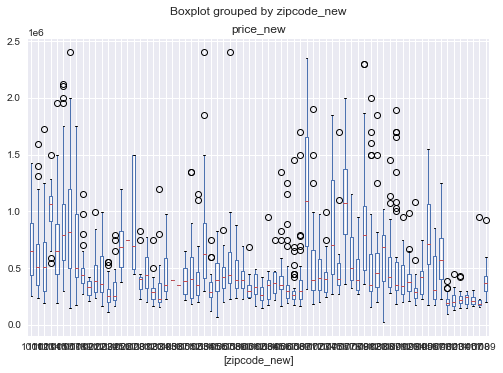

In [5]:
# Boxplot Asking price (EUR) by Zip code + stats by Zip code

data.boxplot(by=["zipcode_new"], column=["price_new"])
plt.show()


In [6]:
print(data['price_new'].groupby(data['zipcode_new']).describe())

             count          mean            std       min       25%  \
zipcode_new                                                           
1011          41.0  6.496585e+05  256307.492063  250000.0  440000.0   
1012          46.0  5.863083e+05  319511.381472  235000.0  350000.0   
1013          56.0  5.559643e+05  317301.517877  189000.0  295000.0   
1014          19.0  1.013373e+06  237235.426607  545995.0  916552.5   
1015          53.0  7.102925e+05  363779.300088  189000.0  450000.0   
1016          55.0  9.035727e+05  489034.303672  295000.0  575000.0   
1017          57.0  9.277721e+05  516830.553439  150000.0  499000.0   
1018          52.0  6.641923e+05  375445.136509  175000.0  418750.0   
1019          46.0  4.710217e+05  172808.145272  275000.0  370500.0   
1021          10.0  3.259500e+05   77435.439059  210000.0  266125.0   
1022           8.0  4.760000e+05  283091.100935  239000.0  287500.0   
1023          20.0  4.804500e+05  272442.842871  165000.0  286750.0   
1024  

In [7]:
# Correlation matrix

corr = data.drop('zipcode_new', axis = 1).corr()
print(corr)

            surface  rooms_new  price_new  latitude  longitude
surface    1.000000   0.649612   0.823487 -0.115107  -0.114502
rooms_new  0.649612   1.000000   0.489848 -0.103204  -0.102522
price_new  0.823487   0.489848   1.000000  0.031215   0.031059
latitude  -0.115107  -0.103204   0.031215  1.000000   0.999906
longitude -0.114502  -0.102522   0.031059  0.999906   1.000000


## Models and Prediction

In [8]:
def model(pipeline, parameters, X_train, y_train, X, y):

    grid_obj = GridSearchCV(estimator=pipeline,
                            param_grid=parameters,
                            cv=3,
                            scoring='r2',
                            verbose=2,
                            n_jobs=1,
                            refit=True)
    grid_obj.fit(X_train, y_train)

    '''Results'''

    results = pd.DataFrame(pd.DataFrame(grid_obj.cv_results_))
    results_sorted = results.sort_values(by=['mean_test_score'], ascending=False)

    print("##### Results")
    print(results_sorted)

    print("best_index", grid_obj.best_index_)
    print("best_score", grid_obj.best_score_)
    print("best_params", grid_obj.best_params_)

    '''Cross Validation'''

    estimator = grid_obj.best_estimator_
    '''
    if estimator.named_steps['scl'] == True:
        X = (X - X.mean()) / (X.std())
        y = (y - y.mean()) / (y.std())
    '''
    shuffle = KFold(n_splits=5,
                    shuffle=True,
                    random_state=0)
    cv_scores = cross_val_score(estimator,
                                X,
                                y.values.ravel(),
                                cv=shuffle,
                                scoring='r2')
    print("##### CV Results")
    print("mean_score", cv_scores.mean())

    '''Show model coefficients or feature importances'''

    try:
        print("Model coefficients: ", list(zip(list(X), estimator.named_steps['clf'].coef_)))
    except:
        print("Model does not support model coefficients")

    try:
        print("Feature importances: ", list(zip(list(X), estimator.named_steps['clf'].feature_importances_)))
    except:
        print("Model does not support feature importances")

    '''Predict along CV and plot y vs. y_predicted in scatter'''

    y_pred = cross_val_predict(estimator, X, y, cv=shuffle)

    plt.scatter(y, y_pred)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
    plt.xlabel("True prices")
    plt.ylabel("Predicted prices")
    plt.annotate(' R-squared CV = {}'.format(round(float(cv_scores.mean()), 3)), size=9,
             xy=(xmin,ymax), xytext=(10, -15), textcoords='offset points')
    plt.annotate(grid_obj.best_params_, size=9,
                 xy=(xmin, ymax), xytext=(10, -35), textcoords='offset points', wrap=True)
    plt.title('Predicted prices (EUR) vs. True prices (EUR)')
    plt.show()


# Pipeline and Parameters - Linear Regression

In [9]:
pipe_ols = Pipeline([('scl', StandardScaler()),
           ('clf', LinearRegression())])

param_ols = {}

# Pipeline and Parameters - XGBoost

In [10]:
pipe_xgb = Pipeline([('clf', xgb.XGBRegressor())])

param_xgb = {'clf__max_depth':[5],
             'clf__min_child_weight':[6],
             'clf__gamma':[0.01],
             'clf__subsample':[0.7],
             'clf__colsample_bytree':[1]}

# Pipeline and Parameters - KNN

In [11]:
pipe_knn = Pipeline([('clf', KNeighborsRegressor())])

param_knn = {'clf__n_neighbors':[5, 10, 15, 25, 30]}

# Pipeline and Parameters - Lasso

In [12]:
pipe_lasso = Pipeline([('scl', StandardScaler()),
           ('clf', Lasso(max_iter=1500))])

param_lasso = {'clf__alpha': [0.01, 0.1, 1, 10]}

# Pipeline and Parameters - Ridge

In [13]:
pipe_ridge = Pipeline([('scl', StandardScaler()),
           ('clf', Ridge())])

param_ridge = {'clf__alpha': [0.01, 0.1, 1, 10]}

# Pipeline and Parameters - Polynomial Regression

In [14]:
pipe_poly = Pipeline([('scl', StandardScaler()),
                       ('polynomial', PolynomialFeatures()),
                       ('clf', LinearRegression())])

param_poly = {'polynomial__degree': [2, 4, 6]}

# Pipeline and Parameters - Decision Tree Regression

In [15]:
pipe_tree = Pipeline([('clf', DecisionTreeRegressor())])

param_tree = {'clf__max_depth': [2, 5, 10],
             'clf__min_samples_leaf': [5,10,50,100]}

# Pipeline and Parameters - Random Forest

In [16]:
pipe_forest = Pipeline([('clf', RandomForestRegressor())])

param_forest = {'clf__n_estimators': [10, 20, 50],
                'clf__max_features': [None, 1, 2],
                'clf__max_depth': [1, 2, 5]}

# Pipeline and Parameters - MLP Regression

In [17]:
pipe_neural = Pipeline([('scl', StandardScaler()),
                        ('clf', MLPRegressor())])

param_neural = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                'clf__hidden_layer_sizes': [(5),(10,10),(7,7,7)],
                'clf__solver': ['lbfgs'],
                'clf__activation': ['relu', 'tanh'],
                'clf__learning_rate' : ['constant', 'invscaling']}

# Execute preprocessing & train/test split

In [18]:
data, X, y = preprocessing(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Execute model hyperparameter tuning and crossvalidation

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.003326      0.000472         0.000331        0.000468     {}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.705744            0.69172           0.668208         0.688557   

   std_test_score  rank_test_score  
0        0.015487                1  
best_index 0
best_score 0.6885572229912578
best_params {}
##### CV Results
mean_score 0.6940028790625163
Model coeffici

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


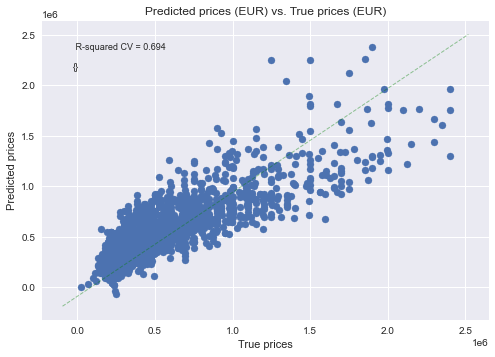

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7, total=   0.1s
[CV] clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7 
[CV]  clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7, total=   0.1s
[CV] clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


[CV]  clf__colsample_bytree=1, clf__gamma=0.01, clf__max_depth=5, clf__min_child_weight=6, clf__subsample=0.7, total=   0.1s
##### Results
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.063829      0.011194         0.003325         0.00047   

  param_clf__colsample_bytree param_clf__gamma param_clf__max_depth  \
0                           1             0.01                    5   

  param_clf__min_child_weight param_clf__subsample  \
0                           6                  0.7   

                                              params  split0_test_score  \
0  {'clf__colsample_bytree': 1, 'clf__gamma': 0.0...           0.862791   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.853519           0.836882         0.851064        0.010719   

   rank_test_score  
0                1  
best_index 0
best_score 0.8510639710839277
best_params {'clf__colsample_bytree': 1, 'clf__gamma': 0.01, 'clf__max_depth': 5, 'cl

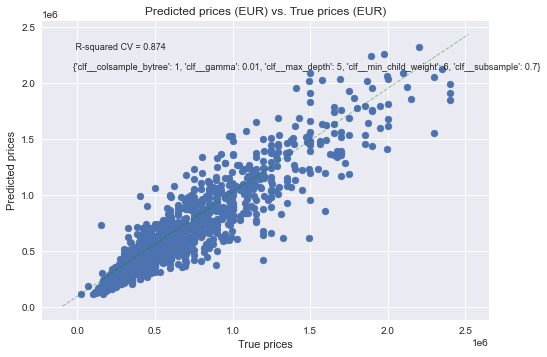

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=5, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=10 .............................................
[CV] .............................. clf__n_neighbors=10, total=   0.0s
[CV] clf__n_neighbors=15 .............................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


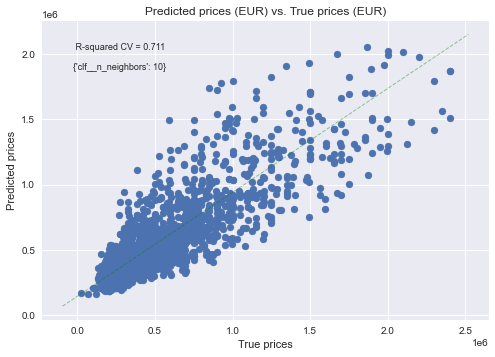

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=1 ....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19832028041896.004, tolerance: 12710705337.082056
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19469799470832.926, tolerance: 12734960585.114794
  positive)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039208147957.39, tolerance: 13467239555.142492
  positive)
C:\Users\Diogo\Anaconda3\lib\site-pa

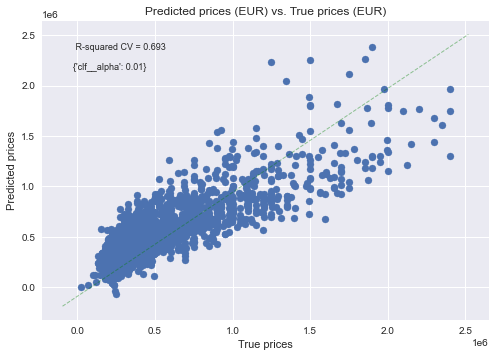

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.01 .................................................
[CV] .................................. clf__alpha=0.01, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=0.1 ..................................................
[CV] ................................... clf__alpha=0.1, total=   0.0s
[CV] clf__alpha=1 ....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished


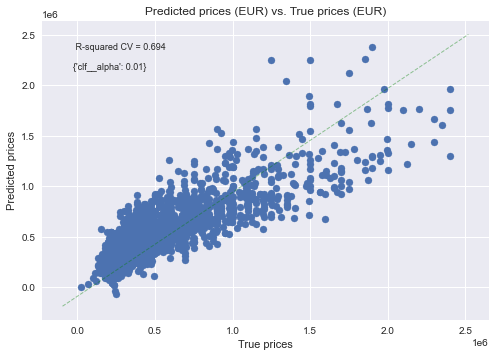

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] polynomial__degree=2 ............................................
[CV] ............................. polynomial__degree=2, total=   0.0s
[CV] polynomial__degree=2 ............................................
[CV] ............................. polynomial__degree=2, total=   0.0s
[CV] polynomial__degree=2 ............................................
[CV] ............................. polynomial__degree=2, total=   0.0s
[CV] polynomial__degree=4 ............................................
[CV] ............................. polynomial__degree=4, total=   0.0s
[CV] polynomial__degree=4 ............................................
[CV] ............................. polynomial__degree=4, total=   0.0s
[CV] polynomial__degree=4 ............................................
[CV] ............................. polynomial__degree=4, total=   0.0s
[CV] polynomial__degree=6 ............................................
[CV] .............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


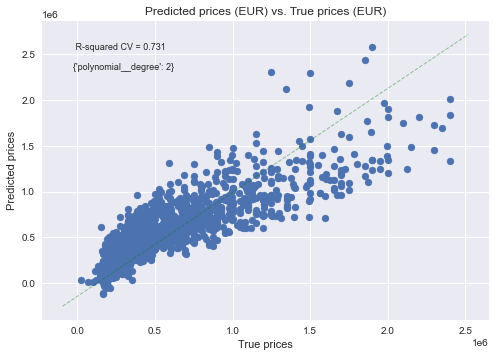

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__max_depth=2, clf__min_samples_leaf=5 .......................
[CV] ........ clf__max_depth=2, clf__min_samples_leaf=5, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=5 .......................
[CV] ........ clf__max_depth=2, clf__min_samples_leaf=5, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=5 .......................
[CV] ........ clf__max_depth=2, clf__min_samples_leaf=5, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=10 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=10, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=10 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=10, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=10 ......................
[CV] ....... clf__max_depth=2, clf__min_samples_leaf=10, total=   0.0s
[CV] clf__max_depth=2, clf__min_samples_leaf=50 ......................
[CV] ....... clf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.0s finished


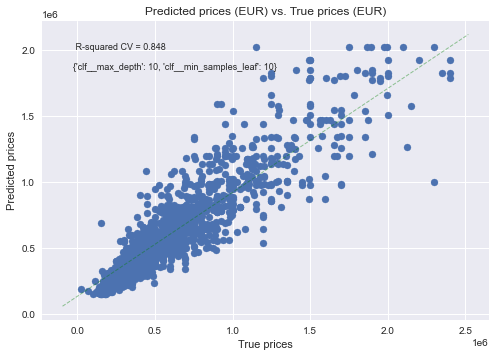

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=10 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=20 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=20 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=None, clf__n_estimators=20 ..
[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=20, total=   0.0s
[CV] clf_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  clf__max_depth=1, clf__max_features=None, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=10 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=20, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=20, total=   0.0s
[CV] clf__max_depth=1, clf__max_features=1, clf__n_estimators=20 .....
[CV]  clf__max_depth=1, clf__max_features=1, clf__n_estimators=20, total=   0.0s
[CV]

[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=50 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=1, clf__n_estimators=50 .....
[CV]  clf__max_depth=5, clf__max_features=1, clf__n_estimators=50, total=   0.1s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=10 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=10, total=   0.0s
[CV] clf__max_depth=5, clf__max_features=2, clf__n_estimators=20 .....
[CV]  clf__max_depth=5, clf__max_features=2, clf__n_estimators=20, total=   0.0s
[CV] cl

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    2.4s finished


##### CV Results
mean_score 0.8444017962120437
Model does not support model coefficients
Feature importances:  [('surface', 0.8312294732795807), ('latitude', 0.03793275915057455), ('longitude', 0.13083776756984478)]


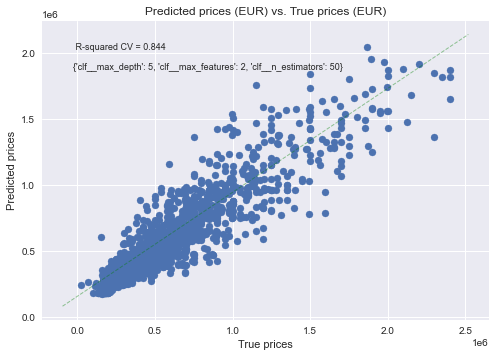

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__lear

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=invscalin

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.01, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, cl

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_la

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=0.1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.6s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.5s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.5s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.6s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5,

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=relu, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=5, clf__learning_rate=i

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=0.1, clf__hidden_layer_

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.9s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), 

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=1, clf__hidden_layer_sizes=(7,

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(10, 10),

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=10, clf__hidden_layer_s

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=10, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf_

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.3s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=5, clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.0s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.8s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(10, 10), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.2s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=constant, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.1s
[CV] clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs 
[CV]  clf__activation=tanh, clf__alpha=100, clf__hidden_layer_sizes=(7, 7, 7), clf__learning_rate=invscaling, clf__solver=lbfgs, total=   0.4s
##### Results

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   39.3s finished



    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
24       0.135310      0.007702         0.001994    6.836514e-07   
2        0.216762      0.024304         0.002661    9.422911e-04   
17       0.362694      0.029497         0.001662    4.698531e-04   
6        0.117684      0.031862         0.001994    0.000000e+00   
9        0.324521      0.042133         0.001993    8.144925e-04   
32       0.252492      0.083673         0.001995    1.946680e-07   
23       0.449324      0.104727         0.002661    1.243859e-03   
21       0.231050      0.107990         0.001994    4.899036e-07   
22       0.505684      0.058539         0.002327    4.704150e-04   
10       0.310170      0.039902         0.001995    5.947204e-07   
27       0.251668      0.023644         0.001994    8.141988e-04   
33       0.290571      0.030183         0.002313    4.797020e-04   
5        0.242021      0.102359         0.001993    8.122537e-04   
11       0.302698      0.035988         0.00232

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

##### CV Results
mean_score 0.7121645946083344
Model does not support model coefficients
Model does not support feature importances


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

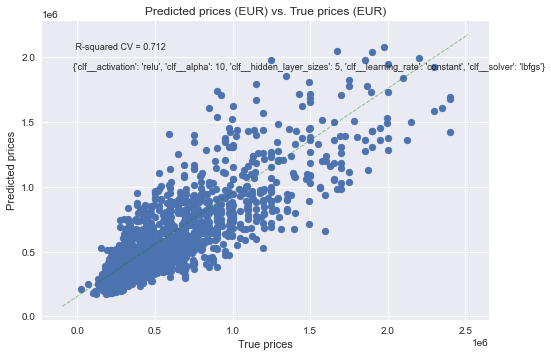

In [19]:
model(pipe_ols, param_ols, X_train, y_train, X, y)
model(pipe_xgb, param_xgb, X_train, y_train, X, y)
model(pipe_knn, param_knn, X_train, y_train, X, y)
model(pipe_lasso, param_lasso, X_train, y_train, X, y)
model(pipe_ridge, param_ridge, X_train, y_train, X, y)
model(pipe_poly, param_poly, X_train, y_train, X, y)
model(pipe_tree, param_tree, X_train, y_train, X, y)
model(pipe_forest, param_forest, X_train, y_train, X, y)
model(pipe_neural, param_neural, X_train, y_train, X, y)